# Key Point Detection

Test pre-trained model to get key points of a human

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
from pathlib import Path

DATA_PATH = Path(
    r"C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images")

In [96]:
import random
import os

from transformers import AutoImageProcessor, SuperPointForKeypointDetection, AutoModelForObjectDetection, pipeline
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import pandas as pd

In [4]:
all_file_paths = []
for path in DATA_PATH.glob("**/*"):
    if path.is_file() and path.suffix == ".jpeg":
        all_file_paths.append(path)

print(f"total files: {len(all_file_paths)}")

total files: 705


In [10]:
object_detect_model_name = "google/owlv2-base-patch16-ensemble"
object_detect_model = pipeline(model=object_detect_model_name, task="zero-shot-object-detection")

super_point_model_name = "magic-leap-community/superpoint"
super_point_processor = AutoImageProcessor.from_pretrained(super_point_model_name)
super_point_model = SuperPointForKeypointDetection.from_pretrained(super_point_model_name)

config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/620M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

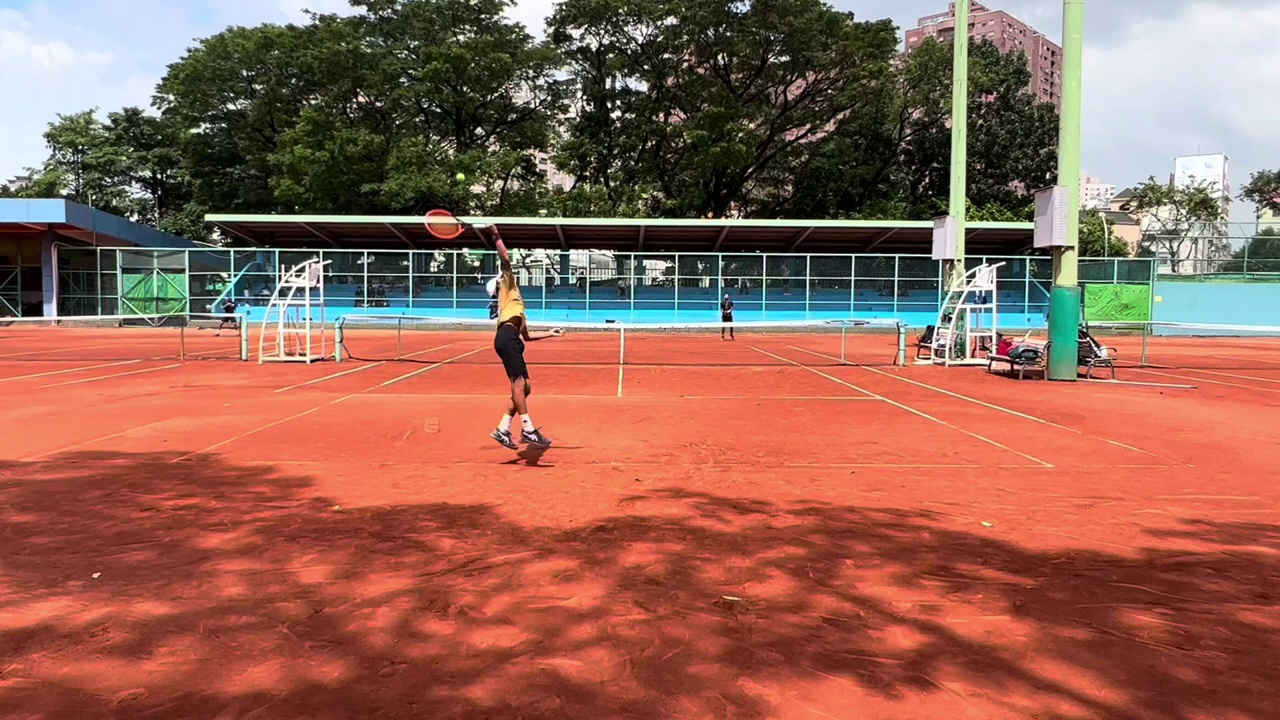

'C:/Users/simu_/OneDrive/Dokumente/Studium Weiterbildung/2023 MAS Data Science FHNW/04_Projektarbeiten/20241102_CAS_Deep_Learning/Tennis_classifier/images/backhand/seq_000/B_000_000.jpeg'

In [100]:
random_file_path = random.choice(all_file_paths)
# random_file_path = all_file_paths[20]
random_image = Image.open(random_file_path)

original_width, original_height = random_image.size

random_image

In [91]:
# Object detection
predictions = object_detect_model(random_image,
                                  candidate_labels=["human"])
predictions

[{'score': 0.11559994518756866,
  'label': 'human',
  'box': {'xmin': 135, 'ymin': 300, 'xmax': 256, 'ymax': 464}}]

In [92]:
predictions_with_size = [dict(pred, **{"size": pred["box"]["ymax"] - pred["box"]["ymin"]}) for pred in predictions]

# the 'largest' detected box might probably be the human of interest
prediction_of_interest = list(sorted(predictions_with_size, key=lambda k: k["size"], reverse=True))[0]
prediction_of_interest

{'score': 0.11559994518756866,
 'label': 'human',
 'box': {'xmin': 135, 'ymin': 300, 'xmax': 256, 'ymax': 464},
 'size': 164}

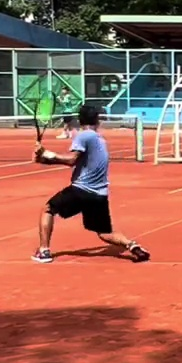

In [94]:
image = random_image.copy()

# draw = ImageDraw.Draw(image)

margin_factor = 1.5
width_to_heigt_ratio = 1 / 2

box = prediction_of_interest["box"]
score = prediction_of_interest["score"]

xmin, ymin, xmax, ymax = box.values()


# x_mid = (xmax+xmin)/2
# x_range = (xmax - xmin) * box_confidence_factor
# y_mid = (ymax+ymin)/2
# y_range = (ymax - ymin) * box_confidence_factor
# 
# x_start, x_end = int(x_mid - (y_range / 2)), int(x_mid + (y_range / 2))
# y_start, y_end = int(y_mid - (y_range / 2)), int(y_mid + (y_range / 2))
# # draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)

def adjust_box_with_aspect_ratio(xmin, ymin, xmax, ymax, img_width, img_height, margin_factor=1.5, aspect_ratio=1 / 2):
    # Original width and height
    box_width = xmax - xmin
    box_height = ymax - ymin

    box_width_with_margin = box_width * margin_factor

    # Center of the box
    center_x = xmin + box_width / 2
    center_y = ymin + box_height / 2

    # Determine new dimensions
    if aspect_ratio > 1:  # Wider
        new_width = max(box_width_with_margin, box_height * aspect_ratio)
        new_height = new_width / aspect_ratio
    else:  # Taller or square
        new_height = max(box_height, box_width_with_margin / aspect_ratio)
        new_width = new_height * aspect_ratio

    # Calculate new coordinates
    new_xmin = max(0, center_x - new_width / 2)
    new_ymin = max(0, center_y - new_height / 2)
    new_xmax = min(img_width, center_x + new_width / 2)
    new_ymax = min(img_height, center_y + new_height / 2)

    return int(new_xmin), int(new_ymin), int(new_xmax), int(new_ymax)


x_start, y_start, x_end, y_end = adjust_box_with_aspect_ratio(xmin, ymin, xmax, ymax, original_width, original_height,
                                                              margin_factor=margin_factor,
                                                              aspect_ratio=width_to_heigt_ratio)

image.crop((x_start, y_start, x_end, y_end))
# image

In [ ]:
def crop_image_and_save(image_path: str):
    image = Image.open(image_path)

    original_width, original_height = image.size

    predictions = object_detect_model(image,
                                      candidate_labels=["human"])

    predictions_with_size = [dict(pred, **{"size": pred["box"]["ymax"] - pred["box"]["ymin"]}) for pred in predictions]

    # the 'largest' detected box might probably be the human of interest
    prediction_of_interest = list(sorted(predictions_with_size, key=lambda k: k["size"], reverse=True))[0]

    margin_factor = 2
    width_to_heigt_ratio = 1 / 2

    box = prediction_of_interest["box"]
    score = prediction_of_interest["score"]

    xmin, ymin, xmax, ymax = box.values()

    x_start, y_start, x_end, y_end = adjust_box_with_aspect_ratio(xmin, ymin, xmax, ymax, original_width,
                                                                  original_height, margin_factor=margin_factor,
                                                                  aspect_ratio=width_to_heigt_ratio)

    new_image = image.crop((x_start, y_start, x_end, y_end))
    
    new_file_path = Path(image_path.replace("/images/", "/images_cropped/"))
    if not new_file_path.parent.exists():
        os.makedirs(new_file_path.parent)
        
    new_image.save(new_file_path)
    print(f"saved file to {new_file_path}")

failed_paths = []
for index, file_path in enumerate(all_file_paths):
    try:
        crop_image_and_save(file_path.as_posix())
    except:
        print(f"FAILED: {file_path}")
        failed_paths.append(file_path)
    percentage = (index+1)/len(all_file_paths) * 100
    print(f"finished {percentage:.2f}%")
    
print("Failed Images: ")
for failed_path in failed_paths:
    print(failed_path)

saved file to C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\backhand\seq_000\B_000_000.jpeg
finished 0.14%
saved file to C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\backhand\seq_000\B_000_001.jpeg
finished 0.28%
saved file to C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\backhand\seq_000\B_000_002.jpeg
finished 0.43%
saved file to C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projektarbeiten\20241102_CAS_Deep_Learning\Tennis_classifier\images_cropped\backhand\seq_000\B_000_003.jpeg
finished 0.57%
saved file to C:\Users\simu_\OneDrive\Dokumente\Studium Weiterbildung\2023 MAS Data Science FHNW\04_Projekta

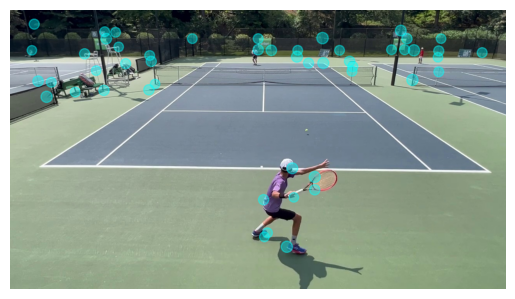

In [32]:
inputs = super_point_processor(image, return_tensors="pt").to(super_point_model.device, super_point_model.dtype)
outputs = super_point_model(**inputs)

# postprocess
image_sizes = [(image.size[1], image.size[0])]
keypoints = outputs.keypoints.detach().numpy()
scores = outputs.scores.detach().numpy()
image_width, image_height = image.size

data = pd.DataFrame({"keypoint_x": keypoints[0, :, 0] / 640 * image_width,
                     "keypoint_y": keypoints[0, :, 1] / 480 * image_height,
                     "score": scores[0, :] * 100})

data = data.sort_values(by="score", ascending=False).iloc[:50, :]

# plot
fig, ax = plt.subplots()
ax.set_axis_off()
ax.imshow(image)
ax.scatter(
    data["keypoint_x"],
    data["keypoint_y"],
    s=data["score"],
    c='cyan',
    alpha=0.4
)
plt.show()
# fig.savefig("key_points_detection_example.png")

In [ ]:
import skimage
import numpy as np
from PIL import Image

image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

image